In [2]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from sac_agent import soft_actor_critic_agent
from replay_memory import ReplayMemory

seed=0  
env = UnityEnvironment(file_name='./Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
torch.manual_seed(seed)
np.random.seed(seed)
max_steps = 500
#print('max_steps: ', max_steps)

batch_size=256

LEARNING_RATE=0.0005 # lr = 0.0001 for BipedalWalker-SAC
eval=True  ## 
load_model=True ## load model weigths
start_steps=10000 ## Steps sampling random actions
replay_size=1000000 ## size of replay buffer
updates_per_step=4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

action_dim = np.ones(action_size)
state_dim  = state_size

agent = soft_actor_critic_agent(state_dim, action_dim, \
        device=device, hidden_size=256, lr=LEARNING_RATE, gamma=0.99, tau=0.005, alpha=0.2)

memory = ReplayMemory(replay_size)

print('device: ', device)
print('state dim: ', state_dim)
print('action dim: ', action_dim)
print('leraning rate: ', LEARNING_RATE)
print('updates_per_step: ', updates_per_step)

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
device:  cuda:0
state dim:  33
action dim:  [1. 1. 1. 1.]
leraning rate:  0.0005
updates_per_step:  4


In [5]:
def save(agent, directory, filename, suffix):
    torch.save(agent.policy.state_dict(), '%s/%s_actor_%s.pth' % (directory, filename, suffix))
    torch.save(agent.critic.state_dict(), '%s/%s_critic_%s.pth' % (directory, filename, suffix))

In [6]:
def load(agent, directory, filename, suffix):
    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    agent.policy.load_state_dict(torch.load('%s/%s_actor_%s.pth' % (directory, filename, suffix), map_location=map_location)) 
    agent.critic.load_state_dict(torch.load('%s/%s_critic_%s.pth' % (directory, filename, suffix), map_location=map_location))

In [7]:
import time
from  collections  import deque

def sac_train(max_steps):

    total_numsteps = 0
    updates = 0
    num_episodes = 3001
    updates=0

    time_start = time.time()
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = [] 
    
    for i_episode in range(num_episodes): 
        episode_reward = 0
        episode_steps = 0
        done = False
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        state = env_info.vector_observations[0]

        for step in range(max_steps):    
            if start_steps > total_numsteps:
                action = np.random.randn(1, action_size) # select an action (for each agent)
                action = np.clip(action, -1, 1)[0]
                
                #action = env.action_space.sample()  # Sample random action
            else:
                action = agent.select_action(state)  # Sample action from policy

            if len(memory) > batch_size:
                
                # Update parameters of all the networks
                agent.update_parameters(memory, batch_size, updates)

                updates += 1

            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]         # get next state (for each agent)
            reward = env_info.rewards[0]                         # get reward (for each agent)
            done = env_info.local_done[0]
            
            #next_state, reward, done, _ = env.step(action) # Step
            episode_steps += 1
            total_numsteps += 1
            episode_reward += reward

            mask = 1 if episode_steps == 500 else float(not done)

            memory.push(state, action, reward, next_state, mask) # Append transition to memory

            state = next_state
            
            if done:
                break

        scores_deque.append(episode_reward)
        scores_array.append(episode_reward)        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        if i_episode % 20 == 0 and i_episode > 0:
            save(agent, 'dir_chk_lr0005', 'weights', 'n'+str(i_episode))

        s =  (int)(time.time() - time_start)
            
        print("Ep.: {}, Total Steps: {}, Ep.Steps: {}, Score: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02}".\
            format(i_episode, total_numsteps, episode_steps, episode_reward, avg_score, \
                  s//3600, s%3600//60, s%60))

                    
        if (avg_score > 30):
            print('Solved environment with Avg Score:  ', avg_score)
            break;
            
    return scores_array, avg_scores_array 

#scores, avg_scores = sac_train(max_steps=max_steps)

In [8]:
if load_model:
   load(agent, 'dir_chk_lr0005', 'weights', '320') 

In [10]:
# Coment nextline if runing in a udacity workspace
scores, avg_scores = sac_train(max_steps=1000)

### Uncoment next lines if runing locally
#from workspace_utils import active_session

#with active_session():
#    scores, avg_scores = sac_train(max_steps=1000)

Ep.: 0, Total Steps: 1000, Ep.Steps: 1000, Score: 0.15, Avg.Score: 0.15, Time: 00:00:21
Ep.: 1, Total Steps: 2000, Ep.Steps: 1000, Score: 0.00, Avg.Score: 0.07, Time: 00:00:53
Ep.: 2, Total Steps: 3000, Ep.Steps: 1000, Score: 0.00, Avg.Score: 0.05, Time: 00:01:16
Ep.: 3, Total Steps: 4000, Ep.Steps: 1000, Score: 0.00, Avg.Score: 0.04, Time: 00:01:35
Ep.: 4, Total Steps: 5000, Ep.Steps: 1000, Score: 0.00, Avg.Score: 0.03, Time: 00:01:53
Ep.: 5, Total Steps: 6000, Ep.Steps: 1000, Score: 0.30, Avg.Score: 0.07, Time: 00:02:10
Ep.: 6, Total Steps: 7000, Ep.Steps: 1000, Score: 0.00, Avg.Score: 0.06, Time: 00:02:28
Ep.: 7, Total Steps: 8000, Ep.Steps: 1000, Score: 0.00, Avg.Score: 0.06, Time: 00:02:46
Ep.: 8, Total Steps: 9000, Ep.Steps: 1000, Score: 0.79, Avg.Score: 0.14, Time: 00:03:03
Ep.: 9, Total Steps: 10000, Ep.Steps: 1000, Score: 0.00, Avg.Score: 0.12, Time: 00:03:22
Ep.: 10, Total Steps: 11000, Ep.Steps: 1000, Score: 0.54, Avg.Score: 0.16, Time: 00:03:40
Ep.: 11, Total Steps: 12000, 

In [11]:
save(agent, 'dir_chk_lr0005', 'weights', 'final')

length of scores:  299 , len of avg_scores:  299


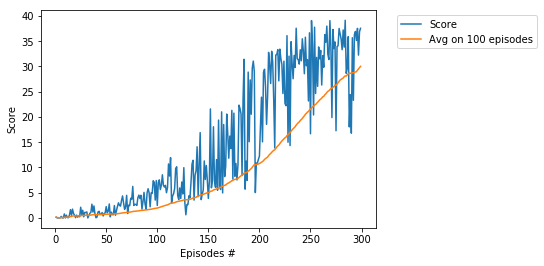

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [8]:
def play(env, agent, num_episodes):
    
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    state = env_info.vector_observations[0]
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(num_episodes + 1):
        
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        state = env_info.vector_observations[0]
        score = 0                    
        time_start = time.time()
        
        while True:
            
            action = agent.select_action(state, eval=True)
            #env.render()
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]         # get next state (for each agent)
            reward = env_info.rewards[0]                         # get reward (for each agent)
            done = env_info.local_done[0]
            score += reward 
            state = next_state
    
            if done:
                break
                
        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)    
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60)) 
    

In [9]:
play(env=env, agent=agent, num_episodes=5)

Episode 0	Average Score: 0.00,	Score: 0.00 	Time: 00:00:01
Episode 1	Average Score: 0.45,	Score: 0.90 	Time: 00:00:01
Episode 2	Average Score: 0.31,	Score: 0.02 	Time: 00:00:01
Episode 3	Average Score: 0.23,	Score: 0.00 	Time: 00:00:01
Episode 4	Average Score: 0.18,	Score: 0.00 	Time: 00:00:01
Episode 5	Average Score: 0.18,	Score: 0.15 	Time: 00:00:01


In [10]:
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
        
agent.policy.load_state_dict(torch.load('dir_chk_lr0005/weights_actor_final.pth', map_location=map_location)) 
agent.critic.load_state_dict(torch.load('dir_chk_lr0005/weights_critic_final.pth', map_location=map_location))

In [12]:
play(env=env, agent=agent, num_episodes=100)

Episode 0	Average Score: 37.07,	Score: 37.07 	Time: 00:00:01
Episode 1	Average Score: 37.21,	Score: 37.36 	Time: 00:00:01
Episode 2	Average Score: 36.97,	Score: 36.49 	Time: 00:00:01
Episode 3	Average Score: 37.00,	Score: 37.09 	Time: 00:00:01
Episode 4	Average Score: 36.50,	Score: 34.49 	Time: 00:00:01
Episode 5	Average Score: 35.73,	Score: 31.87 	Time: 00:00:01
Episode 6	Average Score: 35.47,	Score: 33.94 	Time: 00:00:01
Episode 7	Average Score: 35.74,	Score: 37.65 	Time: 00:00:01
Episode 8	Average Score: 35.63,	Score: 34.73 	Time: 00:00:01
Episode 9	Average Score: 36.01,	Score: 39.41 	Time: 00:00:01
Episode 10	Average Score: 35.43,	Score: 29.58 	Time: 00:00:01
Episode 11	Average Score: 35.57,	Score: 37.11 	Time: 00:00:01
Episode 12	Average Score: 35.72,	Score: 37.61 	Time: 00:00:01
Episode 13	Average Score: 35.81,	Score: 36.95 	Time: 00:00:01
Episode 14	Average Score: 35.11,	Score: 25.27 	Time: 00:00:01
Episode 15	Average Score: 35.26,	Score: 37.52 	Time: 00:00:01
Episode 16	Average

In [13]:
env.close()